In [1]:
import importlib
import time
import math
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy import ndimage

In [2]:
from multi_loc import covariance, assimilate

/home/travisharty/anaconda3/envs/loc/lib/python3.7/site-packages/sklearn/utils/__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence


In [3]:
%matplotlib inline

In [4]:
def imshow(X, title=None, vmin=None, vmax=None, cmap=None):
    plt.figure()
    im = plt.imshow(X, vmin=vmin, vmax=vmax, cmap=cmap)
    plt.colorbar(im)
    plt.title(title)

In [5]:
dimension = 2**9
print(dimension)
rho0_l = 0.3
rho0_s = 0.009
# rho0 = 0.2
# dx = 0.25
dx = 1/dimension

# obs_size = int(dimension/2)
# H = assimilate.random_H(dimension, obs_size)

H = np.eye(dimension)[::2]
obs_size = H.shape[0]

rho = np.arange(dimension, dtype=float)
rho = np.minimum(rho, (dimension - rho) % dimension)
rho = rho*dx
rho = rho*dx

512


In [6]:
eig_val_l, eig_vec_l, P_l, sort_index = covariance.generate_circulant(
    dimension, dx, rho0_l, covariance.fft_sqd_exp_1d,
    return_Corr=True, return_sort_ind=True)
print('long variance: ', eig_val_l.mean())
eig_val_l = eig_val_l / eig_val_l.mean()
sort_index = np.argsort(sort_index)
eig_val_l = eig_val_l[sort_index]
eig_vec_l = eig_vec_l[:, sort_index]
P_l = eig_vec_l @ np.diag(eig_val_l) @ eig_vec_l.conj().T
P_l = P_l.real

eig_val_s, eig_vec_s, P_s, sort_index = covariance.generate_circulant(
    dimension, dx, rho0_s, covariance.fft_sqd_exp_1d,
    return_Corr=True, return_sort_ind=True)
print('short variance: ', eig_val_s.mean())
eig_val_s = eig_val_s / eig_val_s.mean()
sort_index = np.argsort(sort_index)
eig_val_s = eig_val_s[sort_index]
eig_vec_s = eig_vec_s[:, sort_index]
P_s = eig_vec_s @ np.diag(eig_val_s) @ eig_vec_s.conj().T
P_s = P_s.real
#P_s = P_s/P_s.max()

al = 0.5
eig_val = (1 - al) * eig_val_s + al * eig_val_l
eig_vec = eig_vec_l.copy()

eig_val = eig_val / eig_val.mean()

sort_index = np.argsort(eig_val)[::-1]
eig_val = eig_val[sort_index]
eig_vec = eig_vec[:, sort_index]

P = eig_vec @ np.diag(eig_val) @ eig_vec.conj().T
P = P.real

sort_index = np.argsort(eig_val_l)[::-1]
eig_val_l = eig_val_l[sort_index]
eig_vec_l = eig_vec_l[:, sort_index]

sort_index = np.argsort(eig_val_s)[::-1]
eig_val_s = eig_val_s[sort_index]
eig_vec_s = eig_vec_s[:, sort_index]


R = np.eye(obs_size)

trans_mats_true = assimilate.transformation_matrices(
    H, eig_val_p=eig_val, eig_vec_p=eig_vec,
    R=R, return_Ts=True)


trans_mats_long = assimilate.transformation_matrices(
    H, eig_val_p=eig_val_l, eig_vec_p=eig_vec_l,
    R=R, return_Ts=True)


trans_mats_short = assimilate.transformation_matrices(
    H, eig_val_p=eig_val_s, eig_vec_p=eig_vec_s,
    R=R, return_Ts=True)


for key, val in trans_mats_true.items():
    exec(key + '=val')
for key, val in trans_mats_long.items():
    exec(key+'_l' + '=val')
for key, val in trans_mats_short.items():
    exec(key+'_s' + '=val')

long variance:  1.007731840725672
short variance:  1.0


Log10(condition):  19.311096827046455


Text(0.5,0.98,'Eigenvalues P_s')

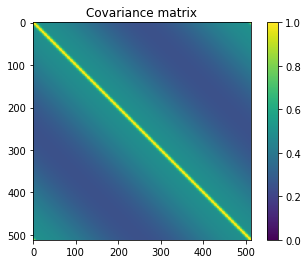

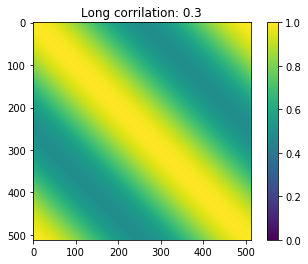

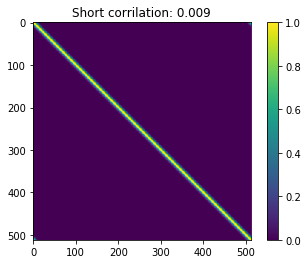

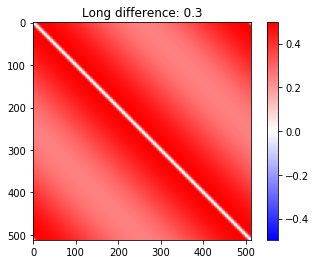

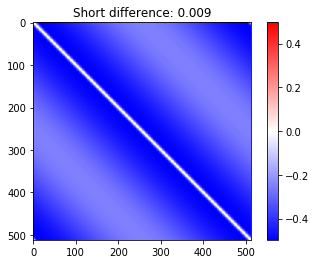

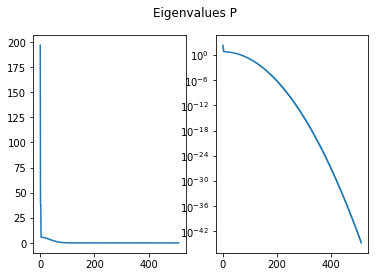

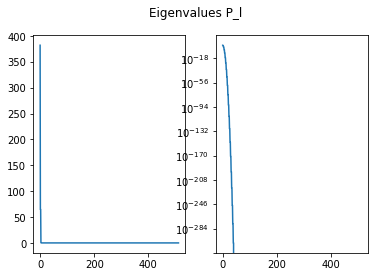

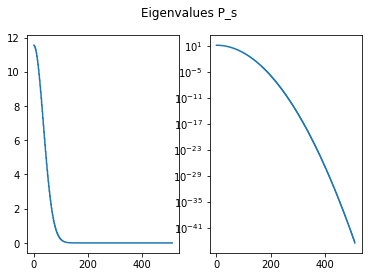

In [7]:
imshow(P, title='Covariance matrix', vmin=0, vmax=1)
imshow(P_l, title=f'Long corrilation: {rho0_l}', vmin=0, vmax=1)
imshow(P_s, title=f'Short corrilation: {rho0_s}', vmin=0, vmax=1)

error_l = P_l - P
error_s = P_s - P

vmax = np.max([np.abs(error_l).max(),
               np.abs(error_s).max()])

imshow(error_l, title=f'Long difference: {rho0_l}',
       vmin=-vmax, vmax=vmax, cmap='bwr')
imshow(error_s, title=f'Short difference: {rho0_s}',
       vmin=-vmax, vmax=vmax, cmap='bwr')
print('Log10(condition): ',
      np.log10(np.linalg.cond(P)))

fig, ax = plt.subplots(1, 2)
ax[0].plot(eig_val)
ax[1].semilogy(eig_val)
plt.suptitle('Eigenvalues P')

fig, ax = plt.subplots(1, 2)
ax[0].plot(eig_val_l)
ax[1].semilogy(eig_val_l)
plt.suptitle('Eigenvalues P_l')

fig, ax = plt.subplots(1, 2)
ax[0].plot(eig_val_s)
ax[1].semilogy(eig_val_s)
plt.suptitle('Eigenvalues P_s')

In [9]:
trans_mats = assimilate.transformation_matrices(
    H, P=P,
    R=R, return_Ts=True)

for key, val in trans_mats.items():
    print(key)
    exec(key + '=val')

P_sqrt
P_inv_sqrt
R_sqrt
R_inv_sqrt
U
S
VT
H
Tx
Tx_inv
Ty
Ty_inv


In [10]:
trans_mats = assimilate.transformation_matrices(
    H, P=P_l,
    R=R, return_Ts=True)

for key, val in trans_mats.items():
    key = key + '_l'
    print(key)
    exec(key + '=val')

P_sqrt_l
P_inv_sqrt_l
R_sqrt_l
R_inv_sqrt_l
U_l
S_l
VT_l
H_l
Tx_l
Tx_inv_l
Ty_l
Ty_inv_l


In [11]:
trans_mats = assimilate.transformation_matrices(
    H, P=P_s,
    R=R, return_Ts=True)

for key, val in trans_mats.items():
    key = key + '_s'
    print(key)
    exec(key + '=val')

P_sqrt_s
P_inv_sqrt_s
R_sqrt_s
R_inv_sqrt_s
U_s
S_s
VT_s
H_s
Tx_s
Tx_inv_s
Ty_s
Ty_inv_s


In [138]:
ens_size = 500
mu = np.zeros(dimension)
ensemble = (
    assimilate.generate_ensemble(
        ens_size, mu, P_sqrt))
P_sample = np.cov(ensemble)

In [145]:
sig_max = 200
rho_array = np.linspace(0.008, 0.6, 20)
# rho_array = np.array(
#     [0.595, 0.175, 0.115, 0.085, 0.07 , 0.055, 0.04 , 0.025])


# small_rho = np.linspace(0.001, 0.03, 5)
# long_rho = np.linspace(0.1, 0.6, 5)
# rho_array = np.concatenate([small_rho, long_rho])

# rho_array = np.array([0.001, 0.005, 0.01, 0.1, 0.2, 0.3, 0.4])
# rho_array = np.arange(0.01, .11, .01)
print(rho_array)
U_array = np.ones([rho_array.size, obs_size, sig_max])
s_array = np.ones([rho_array.size, sig_max])
V_array = np.ones([rho_array.size, dimension, sig_max])

[0.008      0.03915789 0.07031579 0.10147368 0.13263158 0.16378947
 0.19494737 0.22610526 0.25726316 0.28842105 0.31957895 0.35073684
 0.38189474 0.41305263 0.44421053 0.47536842 0.50652632 0.53768421
 0.56884211 0.6       ]


In [146]:
vmin = np.min(
    [P.min(), P_sample.min()])
vmax = np.max(
    [P.max(), P_sample.max()])
# imshow(P, 'True covariance', vmin=vmin, vmax=vmax)
# imshow(P_sample, 'Sample covariance',
#        vmin=vmin, vmax=vmax)

for rho_loc in rho_array:
    [loc] = covariance.generate_circulant(
        dimension, dx, rho_loc, covariance.fft_sqd_exp_1d,
        return_Corr=True, return_eig=False)
    loc /= loc.max()
    P_loc = P_sample * loc
#     imshow(loc, f'loc_matrix: {rho_loc}', vmin=0)
#     imshow(P_loc, title=f'P_loc: {np.round(rho_loc, 2)}',
#            vmin=vmin, vmax=vmax)

In [147]:
for rho_count, rho_loc in enumerate(rho_array):
    [loc] = covariance.generate_circulant(
        dimension, dx, rho_loc, covariance.fft_sqd_exp_1d,
        return_Corr=True, return_eig=False)
    loc /= loc.max()
    P_loc = P_sample * loc
    P_loc_sqrt = covariance.matrix_sqrt(P_loc).real
    aU, aS, aVT = sp.linalg.svd(H @ P_loc_sqrt)
    U_array[rho_count] = aU[:, :sig_max]
    s_array[rho_count] = aS[:sig_max]
    V_array[rho_count] = aVT[:sig_max].T

In [148]:
dpi = 300

In [149]:
component_number = np.arange(0, sig_max) + 1

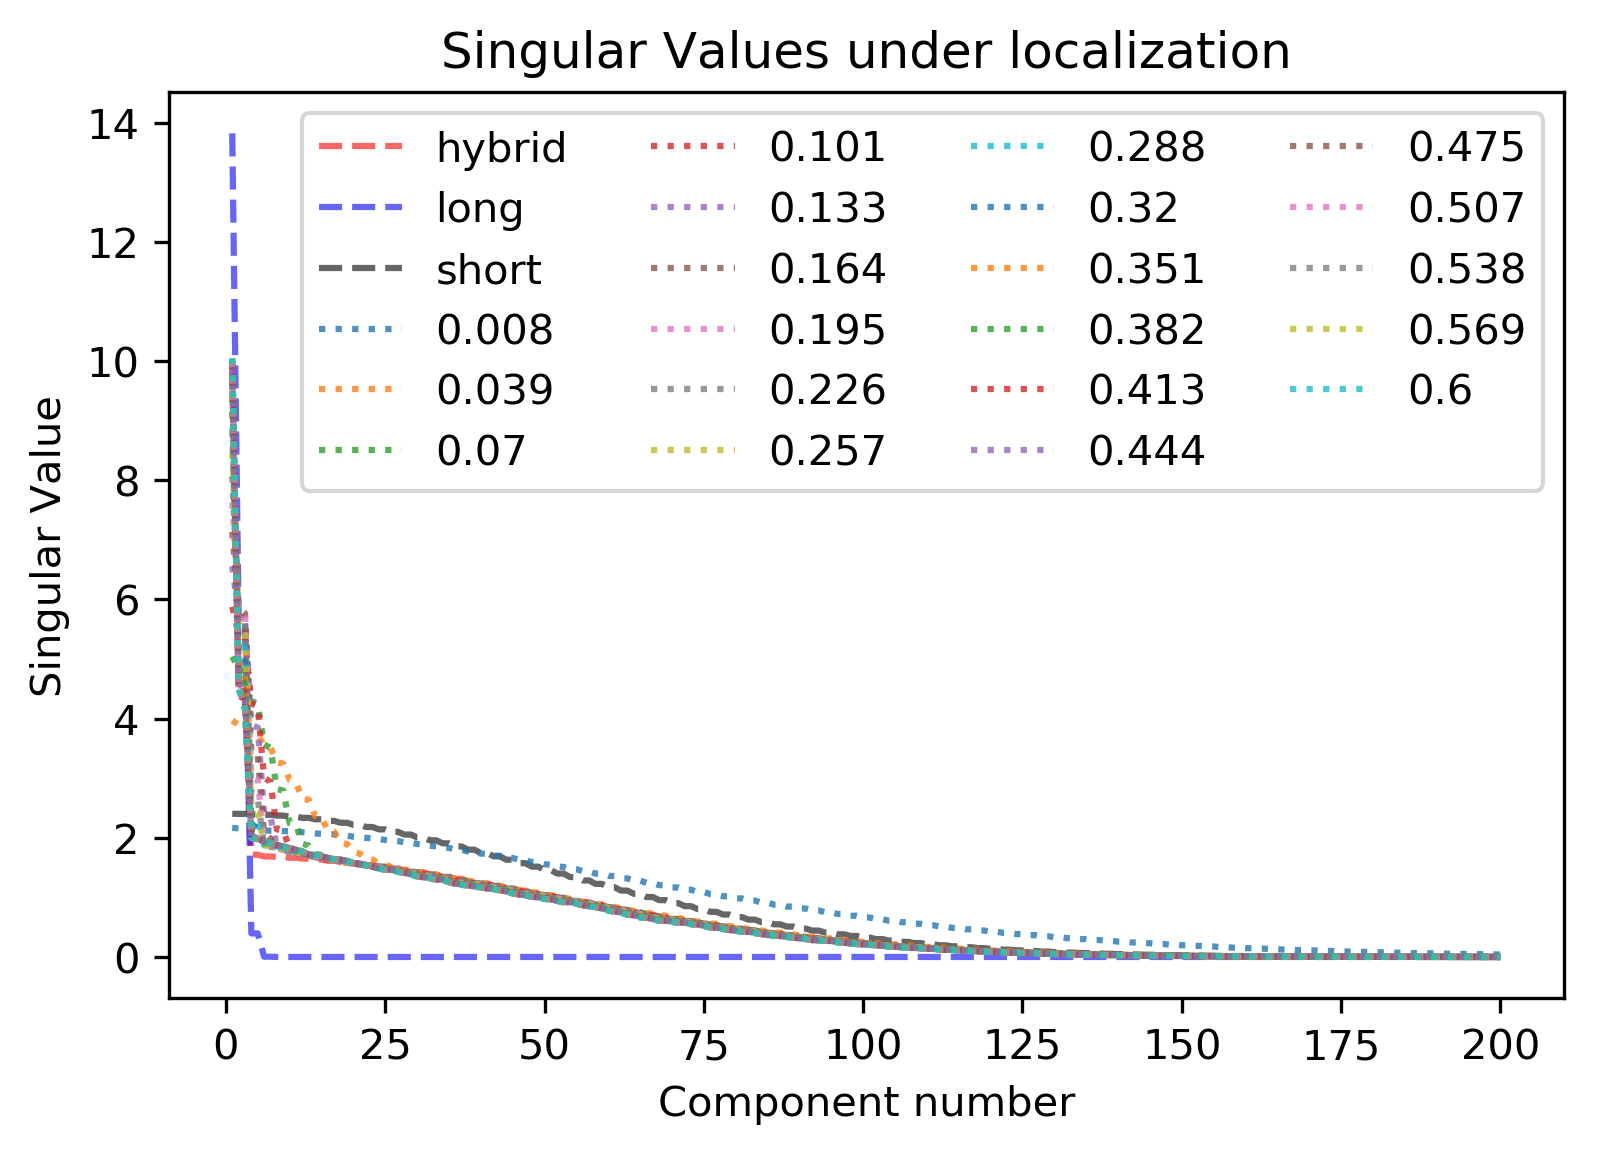

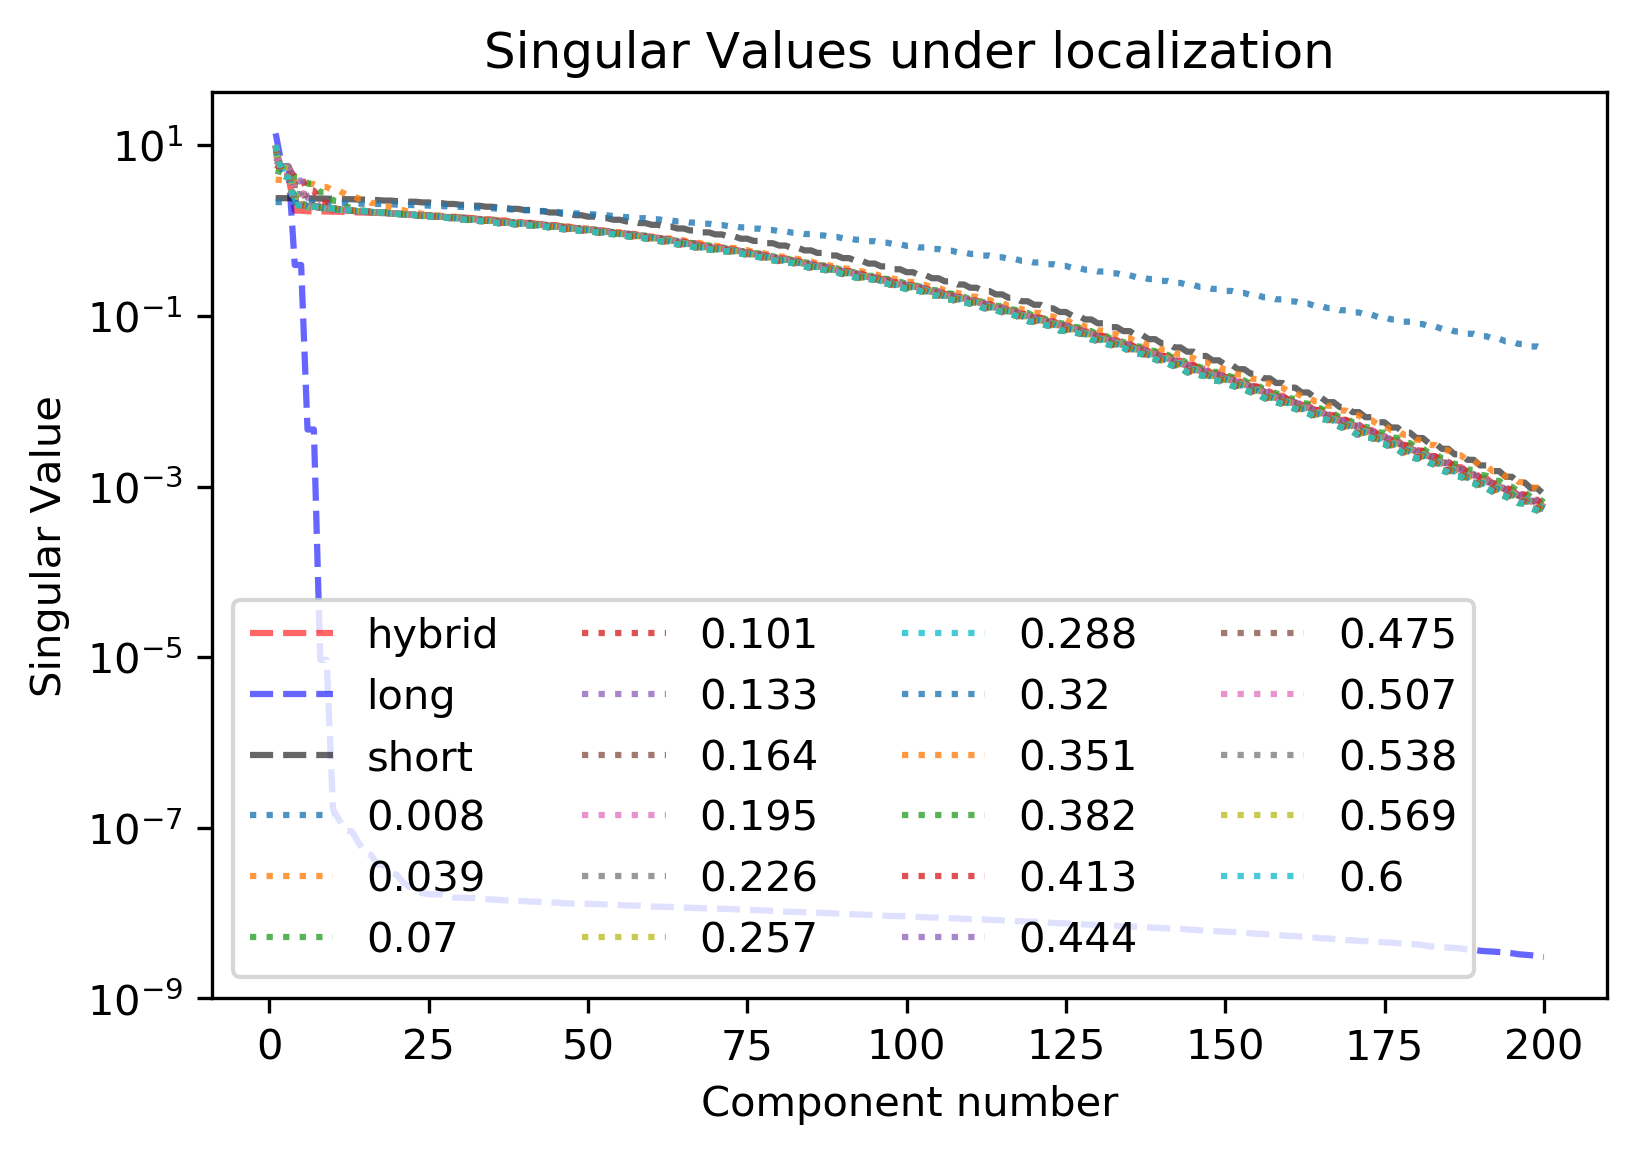

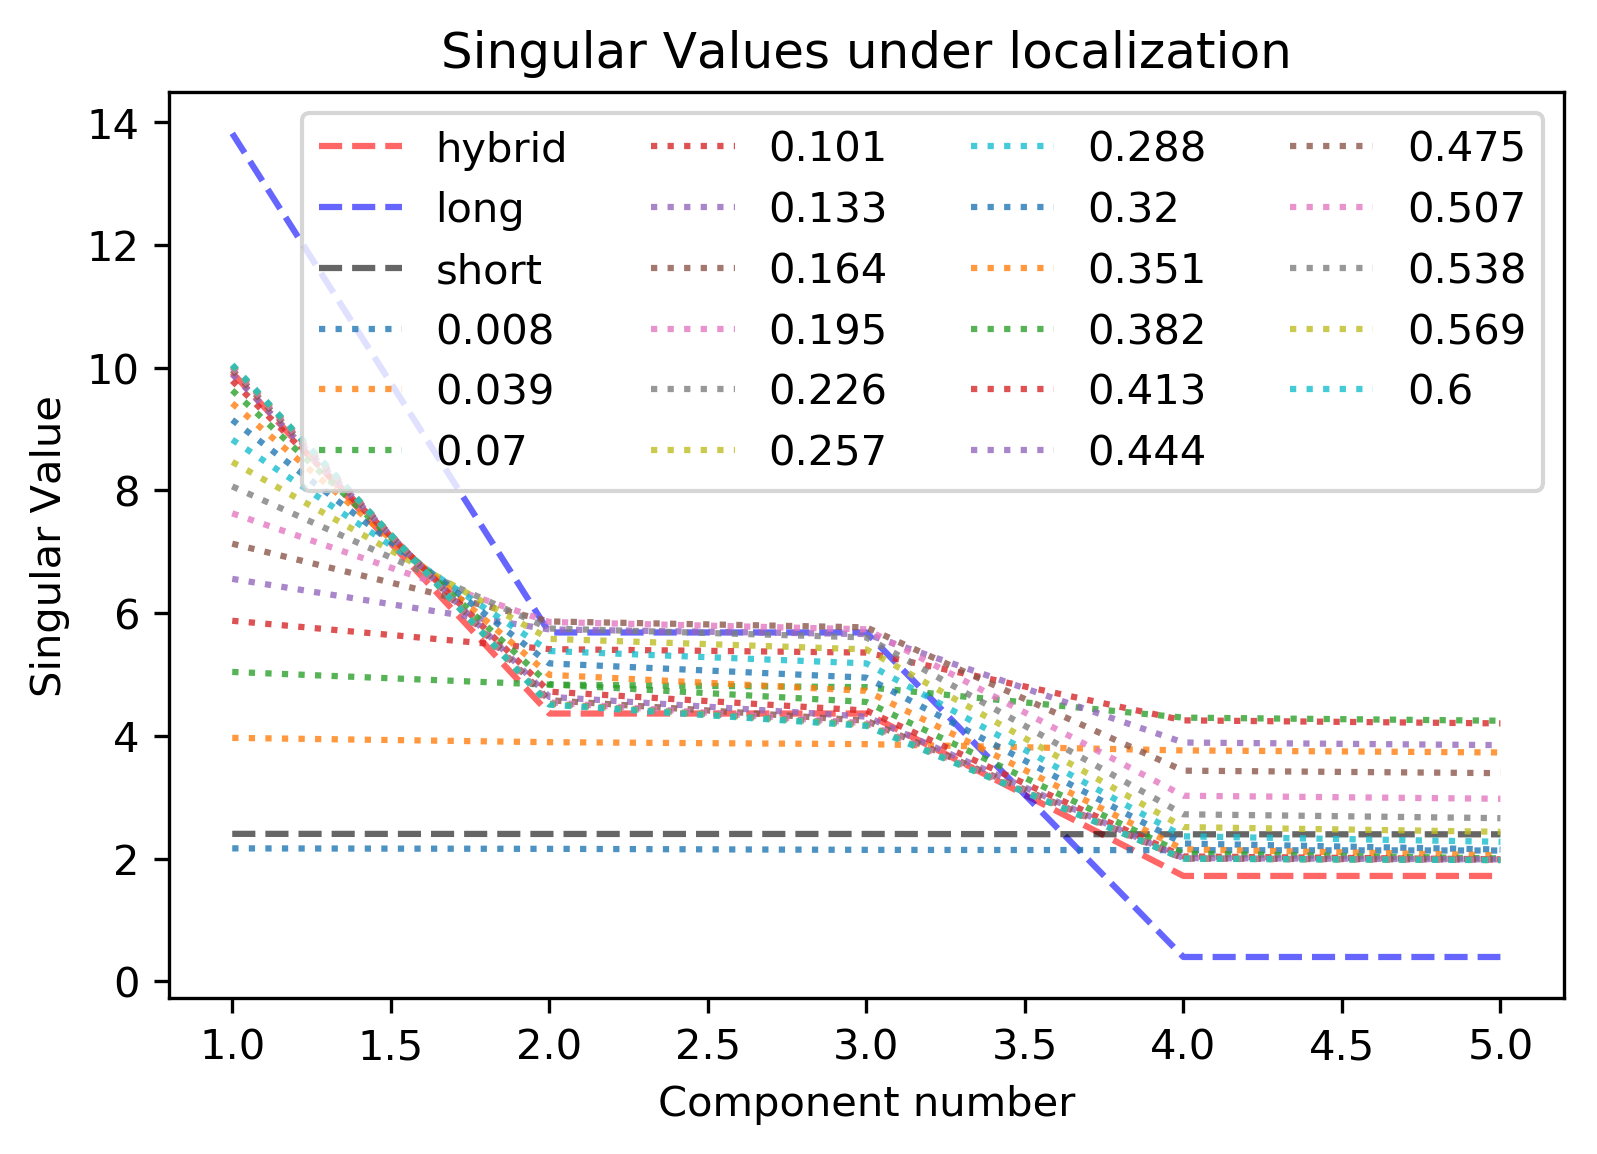

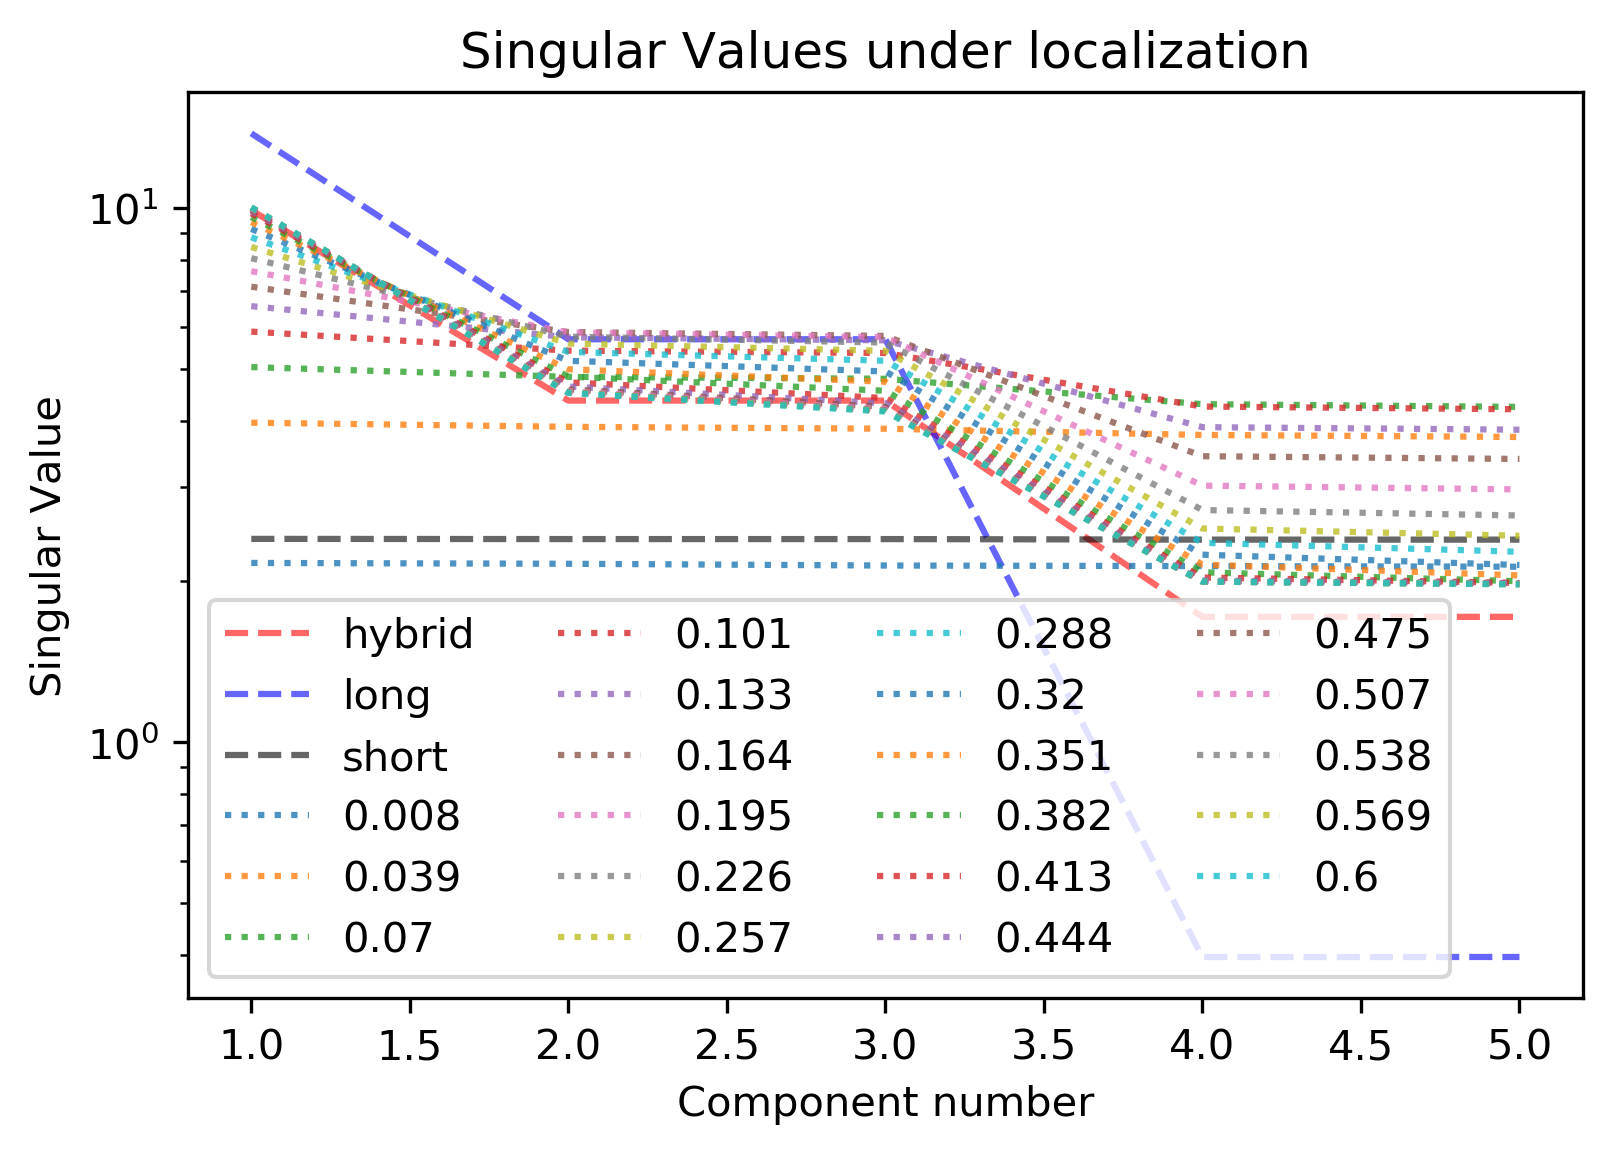

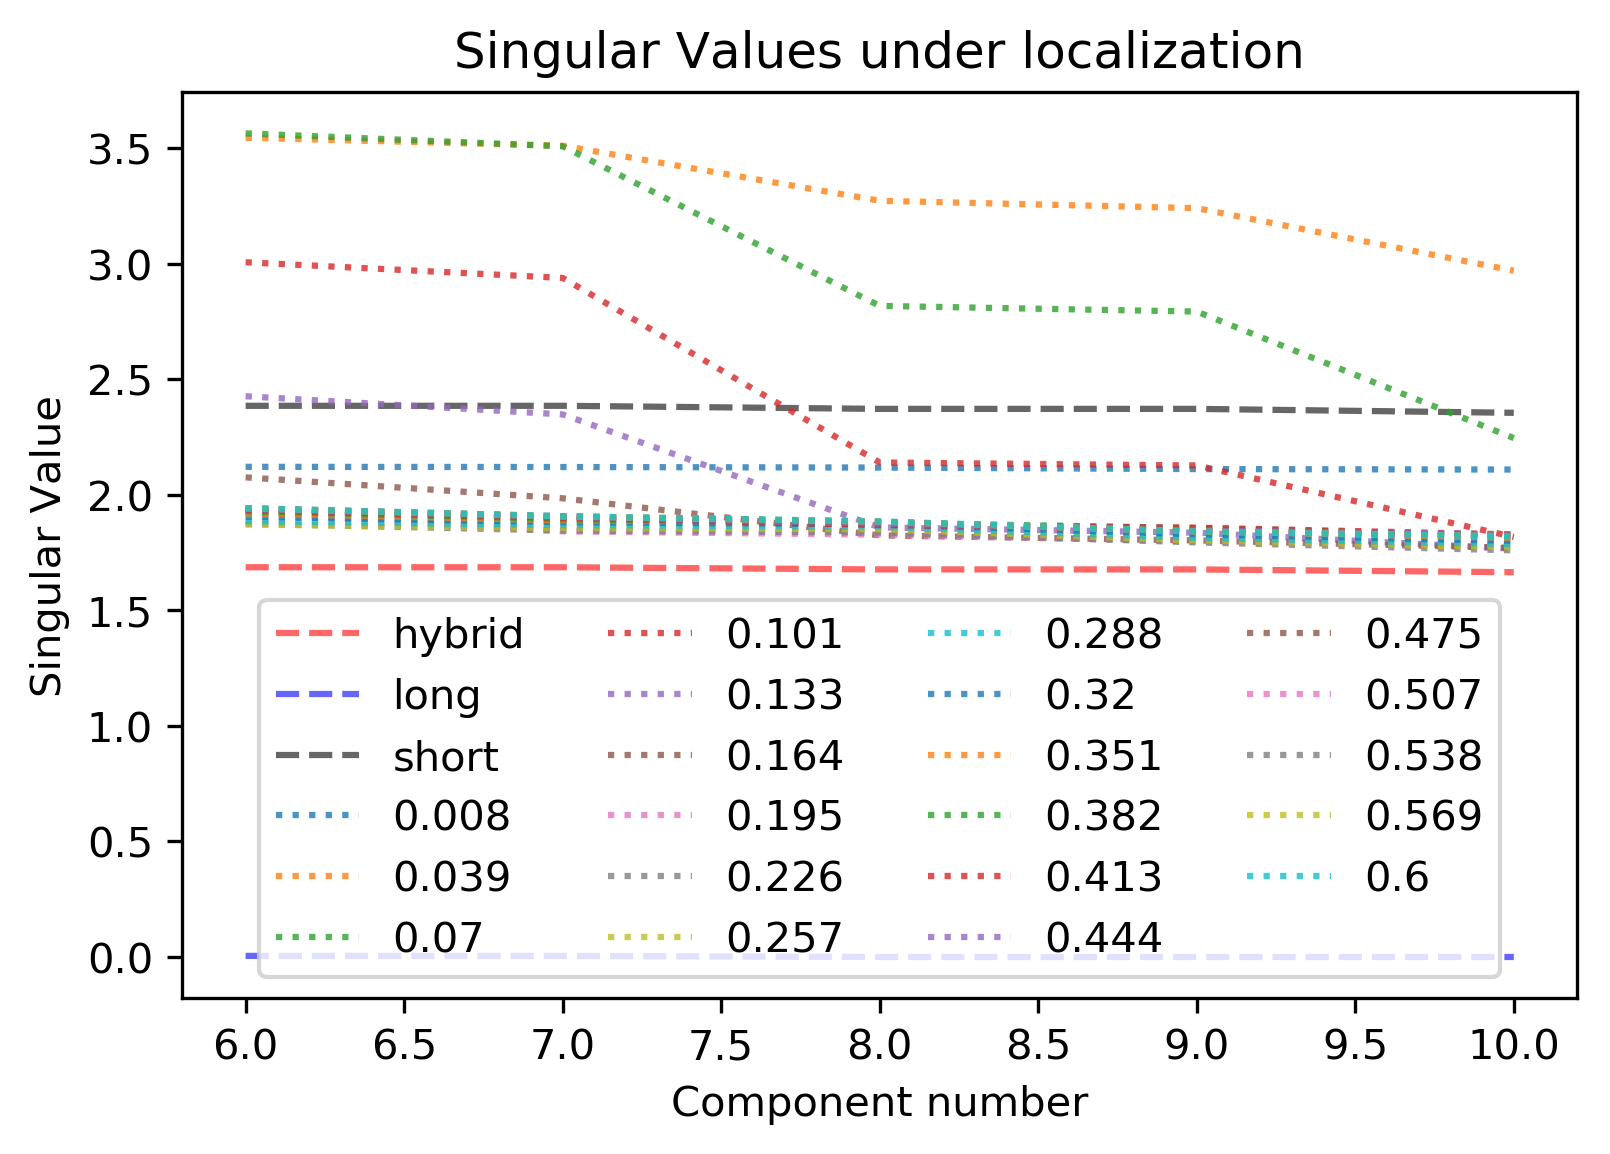

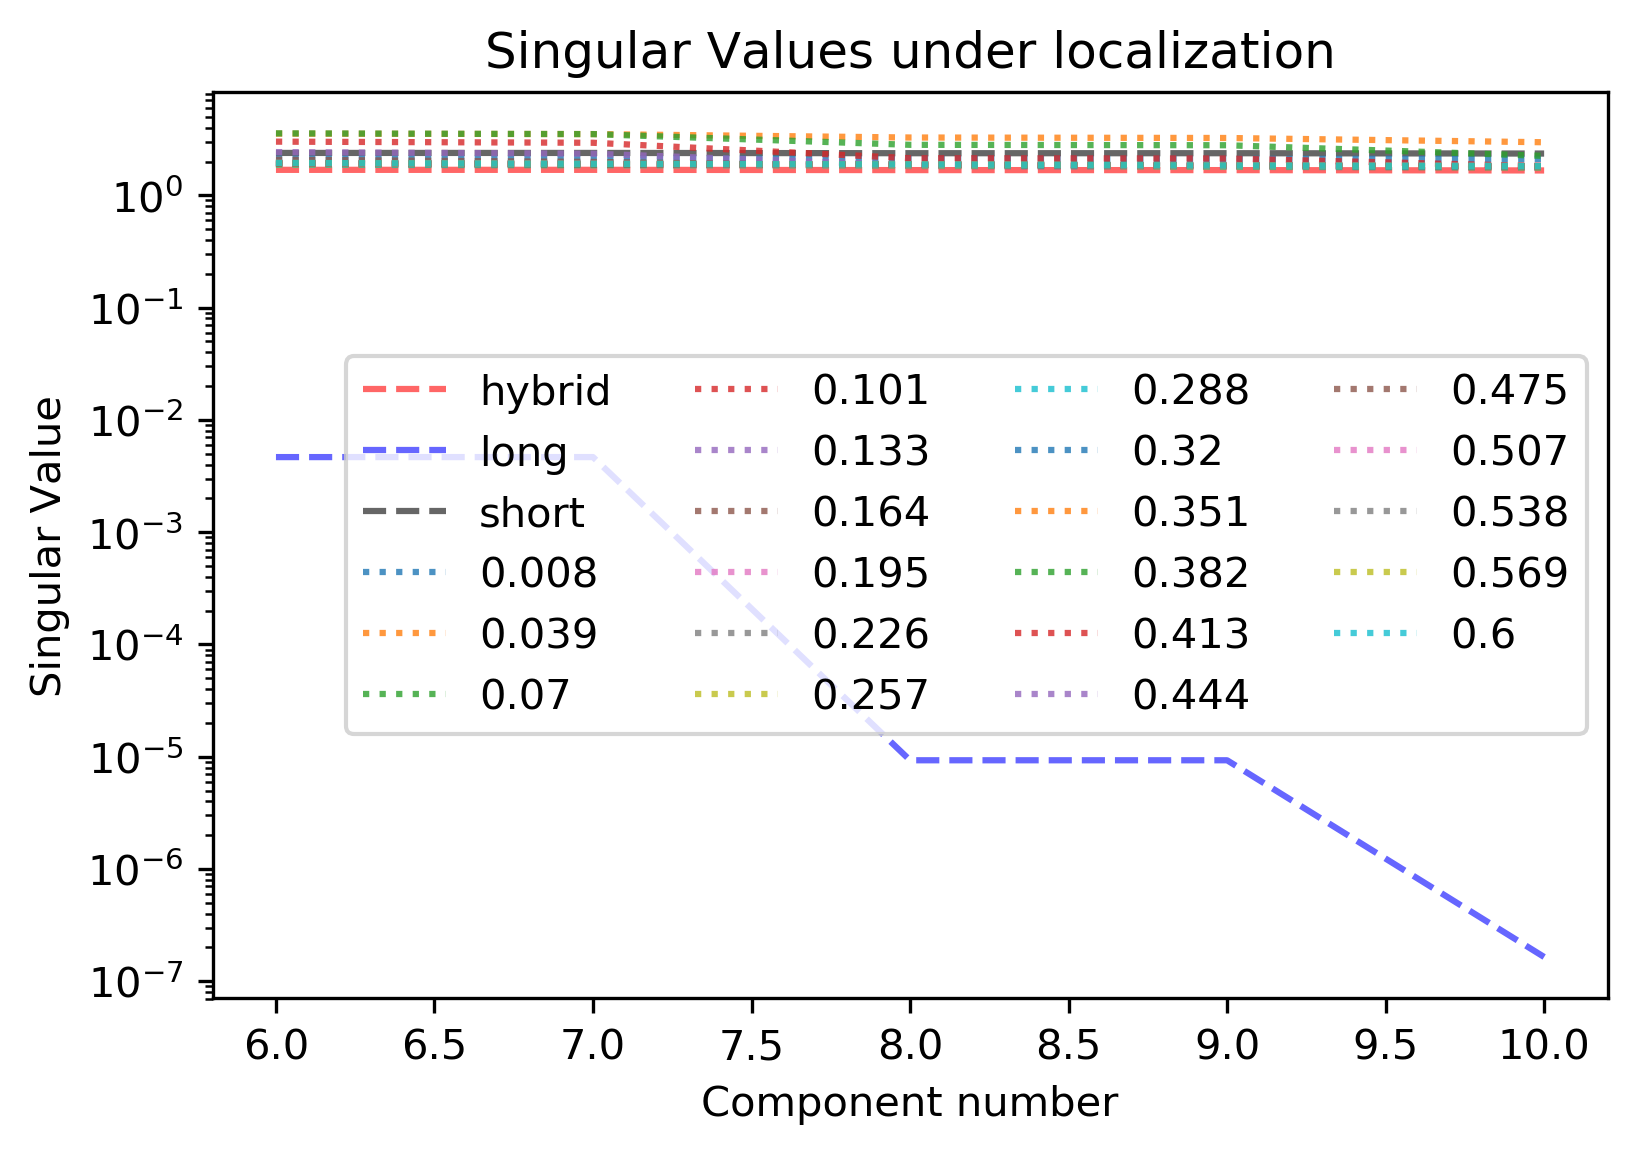

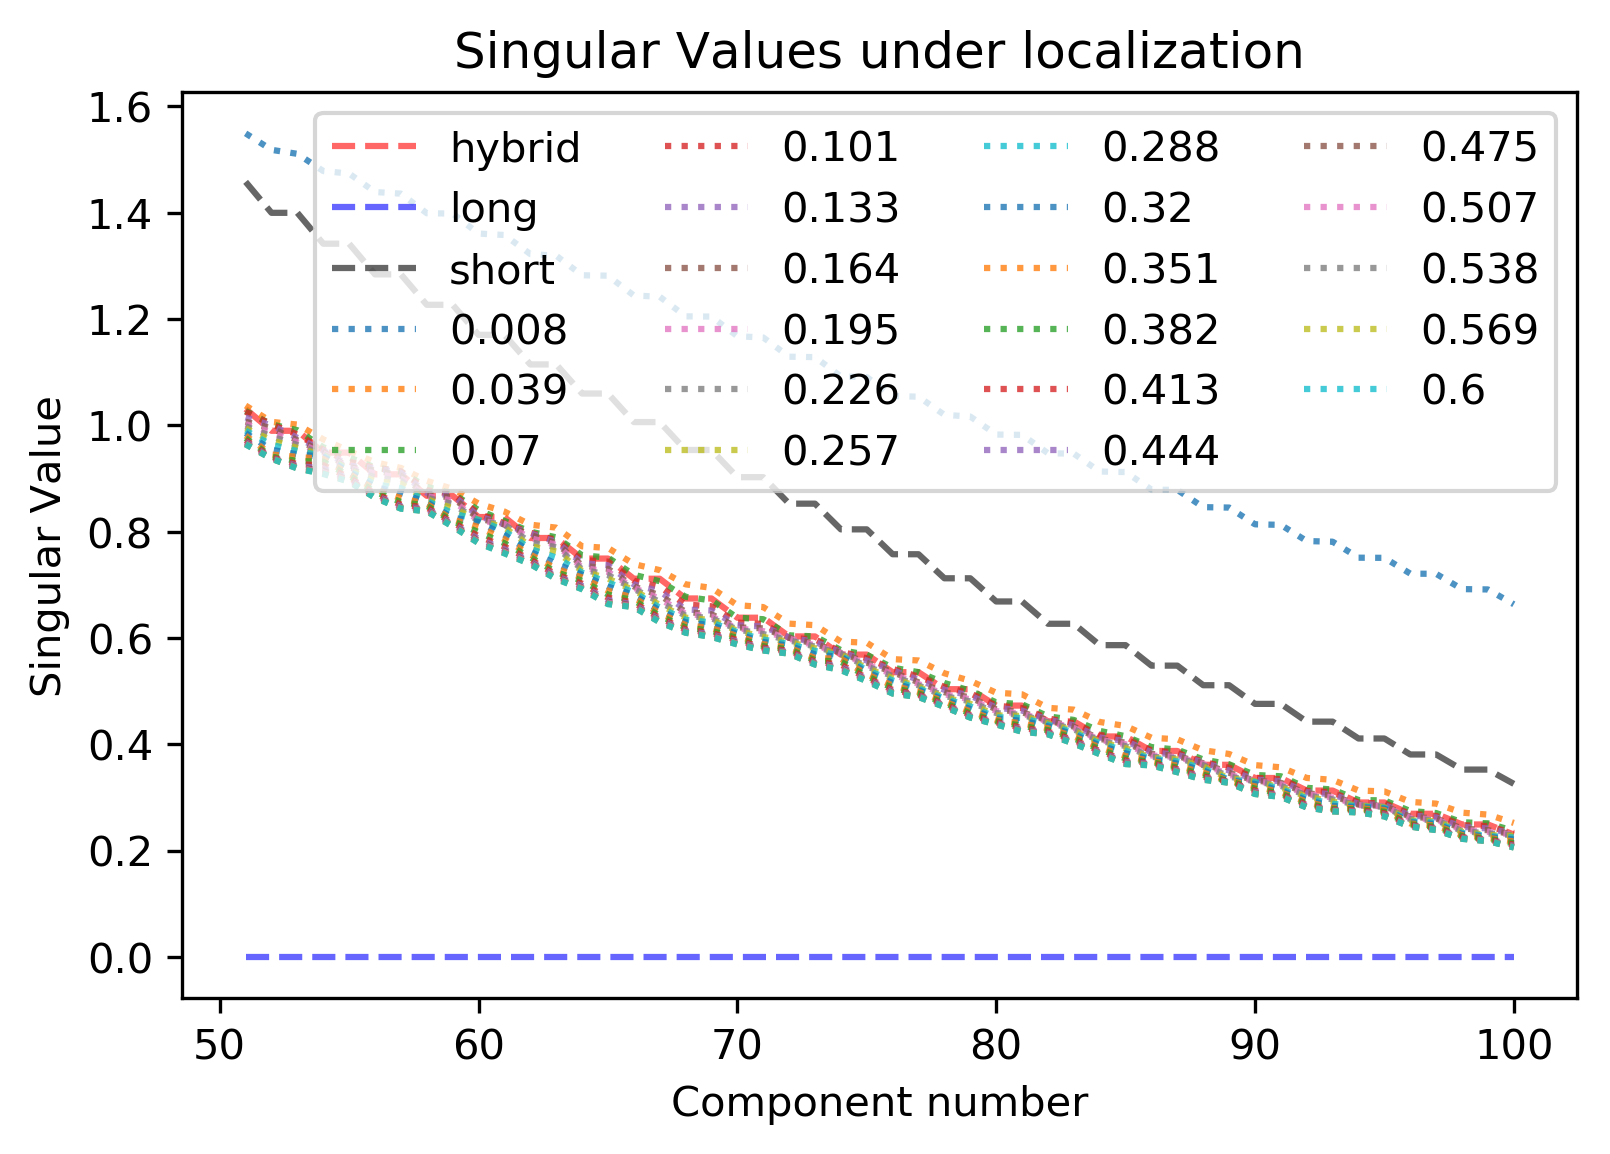

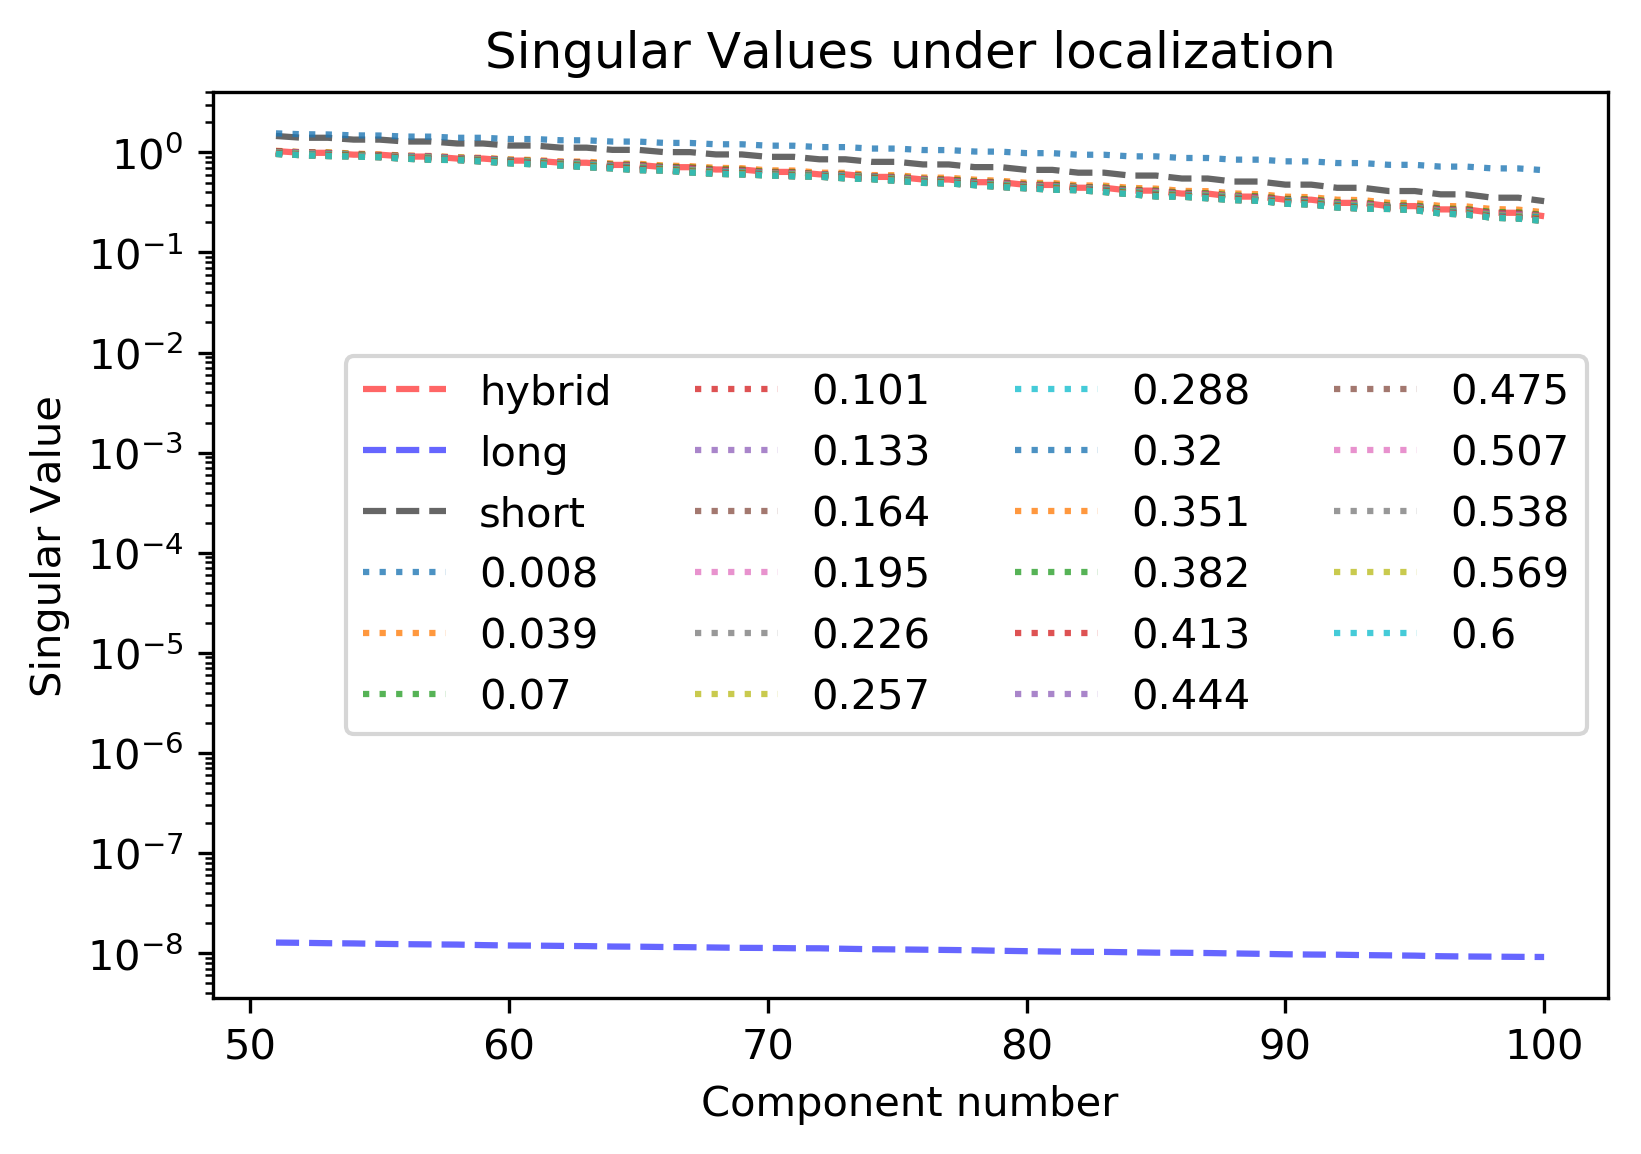

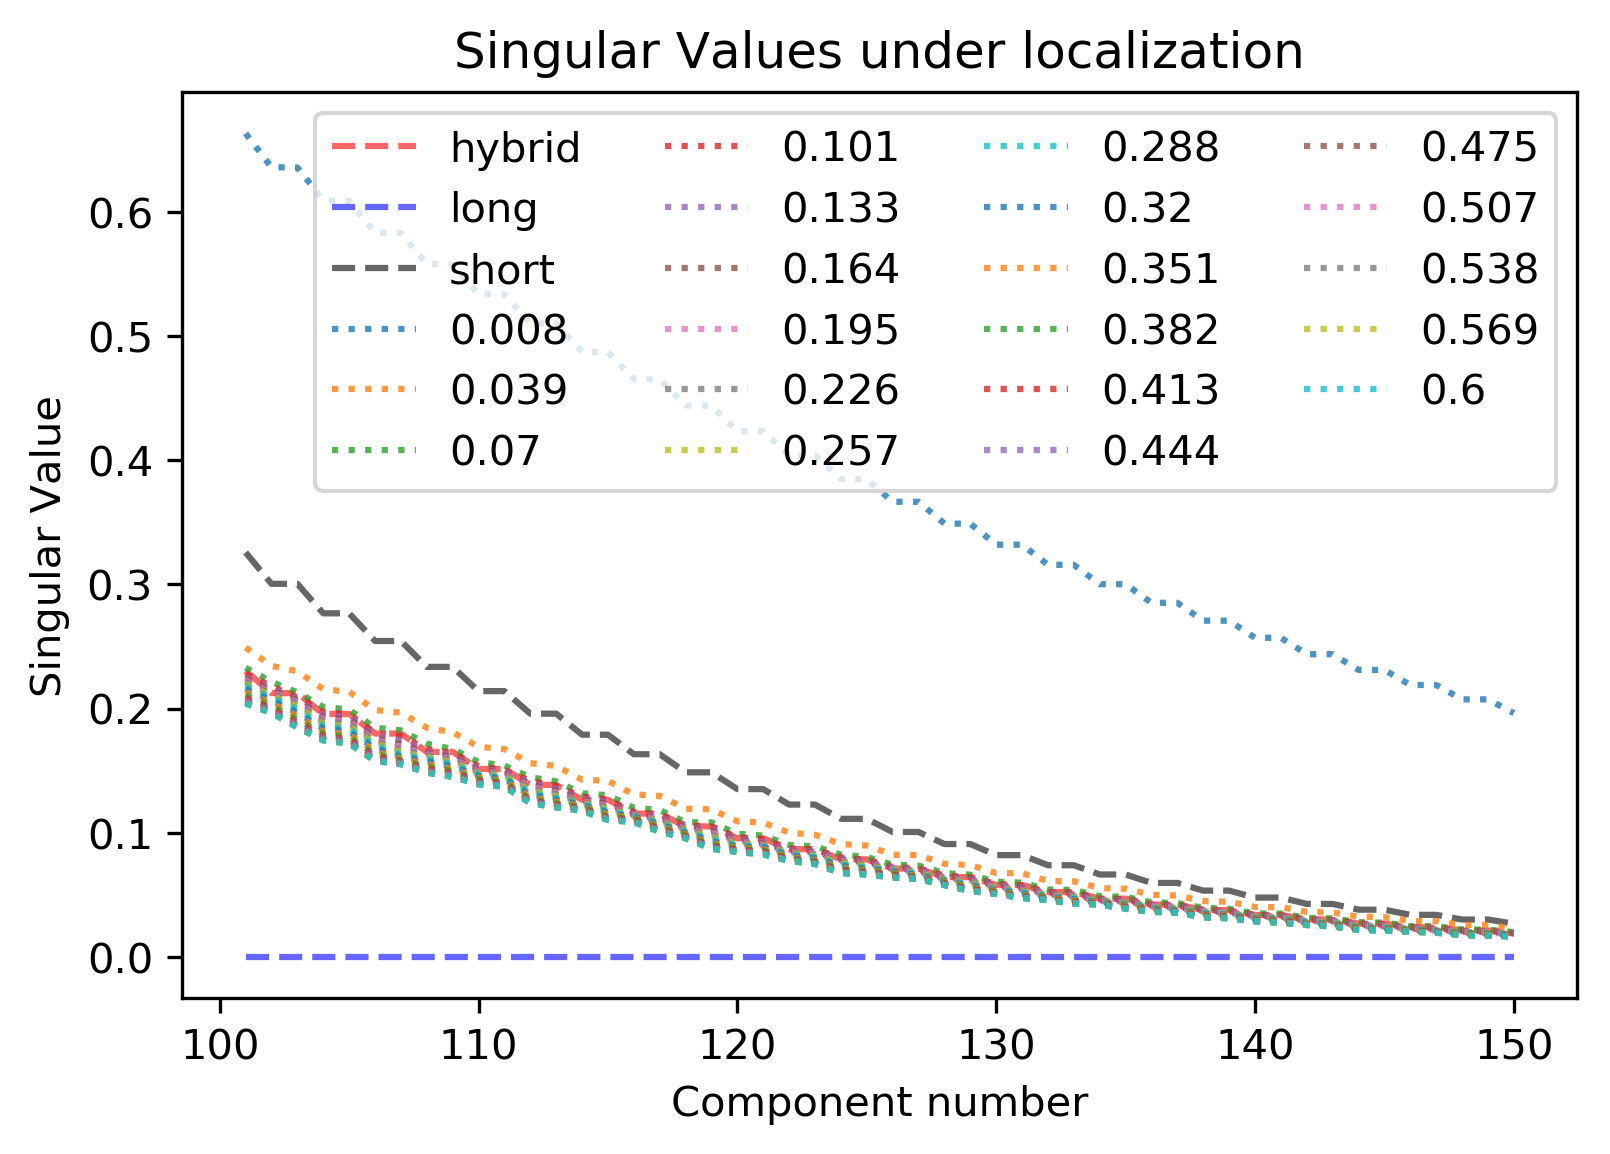

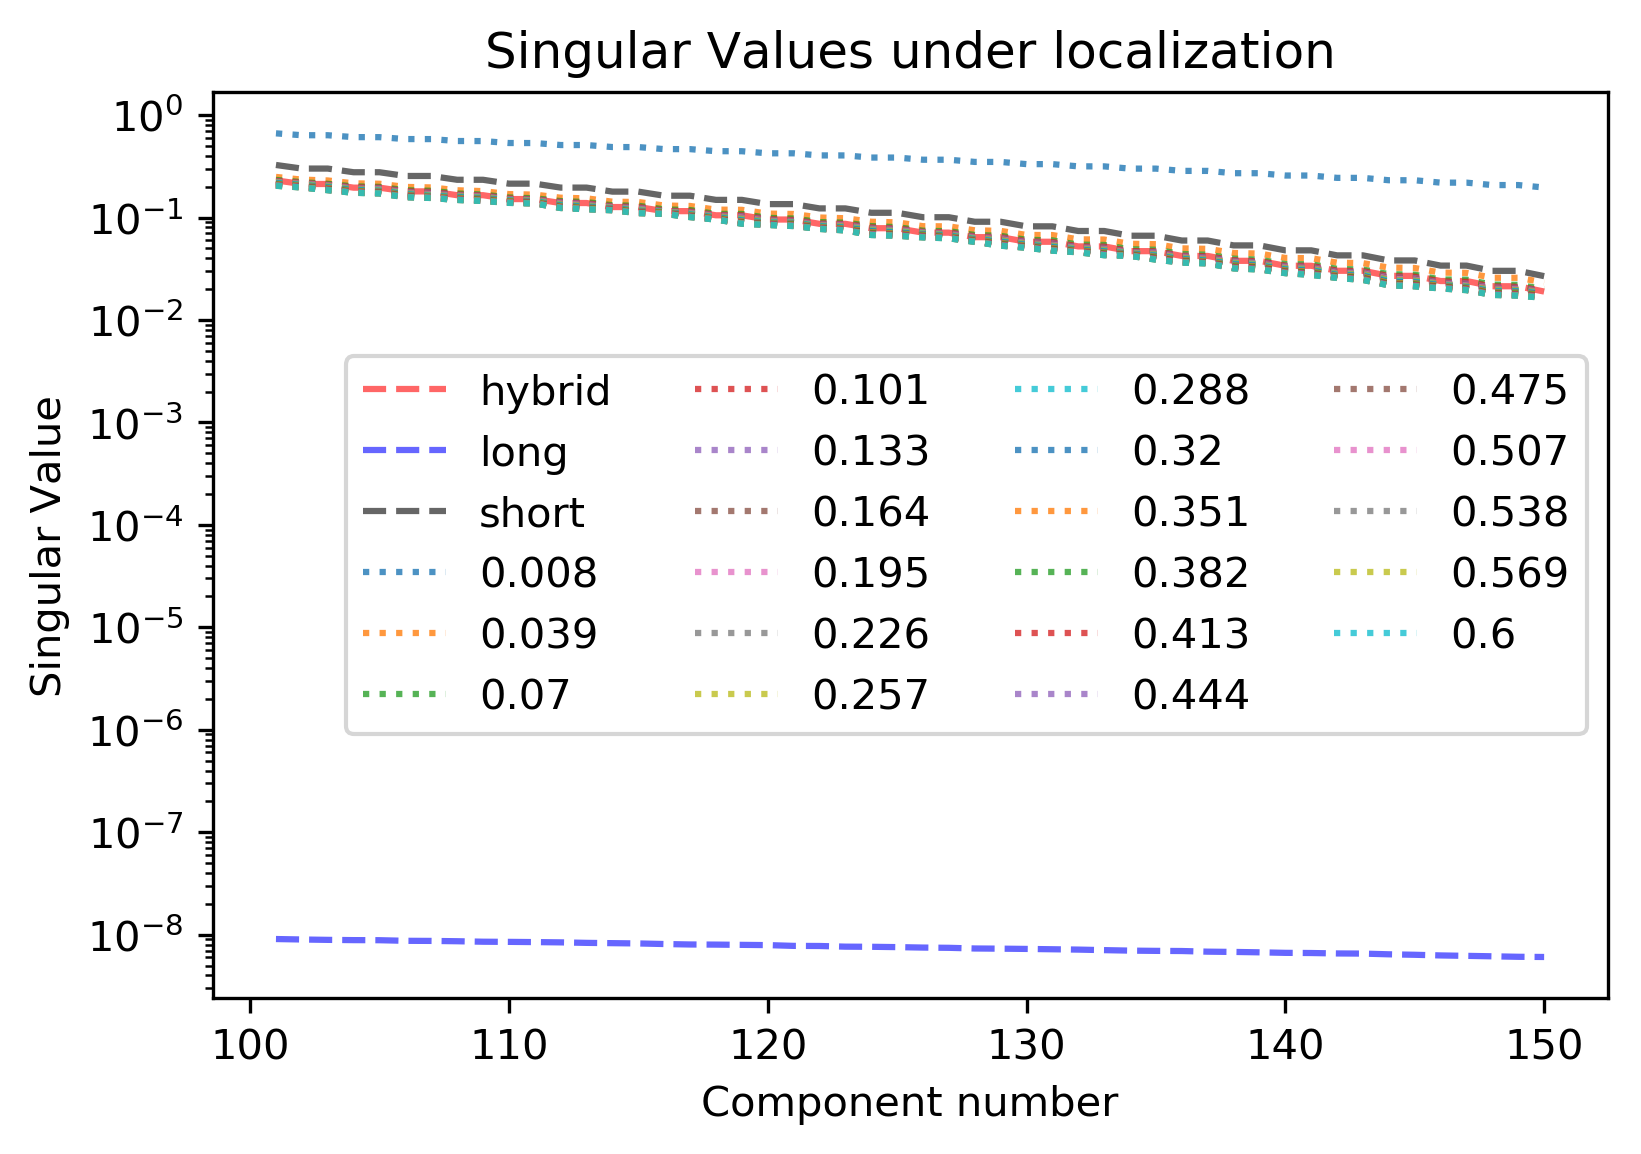

In [150]:
component_number = np.arange(0, sig_max) + 1
for this_sig_min, this_sig_max in [(0, sig_max), (0, 5), (5, 10), (50, 100), (100, 150)]:
    plt.figure(dpi=dpi)
    plt.plot(component_number[this_sig_min:this_sig_max],
             S.diagonal()[this_sig_min:this_sig_max], 'r--', alpha=.6)
    plt.plot(component_number[this_sig_min:this_sig_max],
             S_l.diagonal()[this_sig_min:this_sig_max], 'b--', alpha=.6)
    plt.plot(component_number[this_sig_min:this_sig_max],
             S_s.diagonal()[this_sig_min:this_sig_max], 'k--', alpha=.6)
    plt.plot(component_number[this_sig_min:this_sig_max],
             s_array.T[this_sig_min:this_sig_max], ':', alpha=.8)

    plt.title('Singular Values under localization')
    plt.xlabel('Component number')
    plt.ylabel('Singular Value')
#     plt.legend(['hybrid', 'long', 'short'] , ncol=4)
    plt.legend(['hybrid', 'long', 'short']
               + list(np.round(rho_array, 3)), ncol=4)


    plt.figure(dpi=dpi)
    plt.semilogy(component_number[this_sig_min:this_sig_max],
                 S.diagonal()[this_sig_min:this_sig_max], 'r--', alpha=.6)
    plt.semilogy(component_number[this_sig_min:this_sig_max],
                 S_l.diagonal()[this_sig_min:this_sig_max], 'b--', alpha=.6)
    plt.semilogy(component_number[this_sig_min:this_sig_max],
                 S_s.diagonal()[this_sig_min:this_sig_max], 'k--', alpha=.6)
    plt.semilogy(component_number[this_sig_min:this_sig_max],
                 s_array.T[this_sig_min:this_sig_max], ':', alpha=.8)
    plt.title('Singular Values under localization')
    plt.xlabel('Component number')
    plt.ylabel('Singular Value')
#     plt.legend(['hybrid', 'long', 'short'] , ncol=4)
    plt.legend(['hybrid', 'long', 'short']
               + list(np.round(rho_array, 3)), ncol=4)

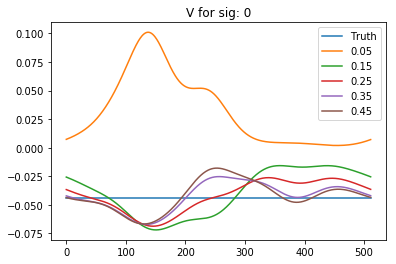

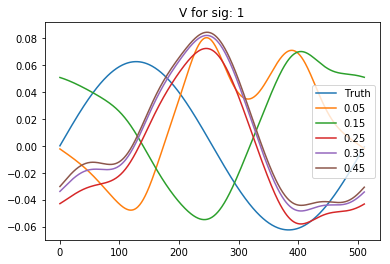

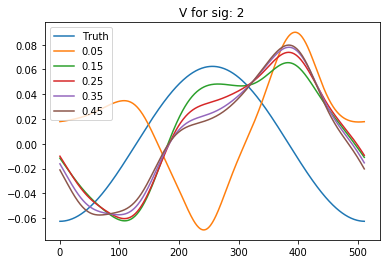

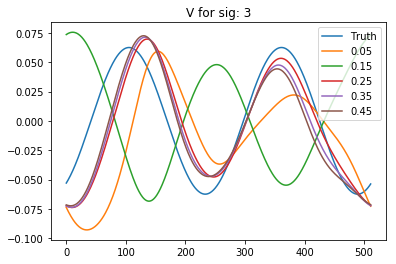

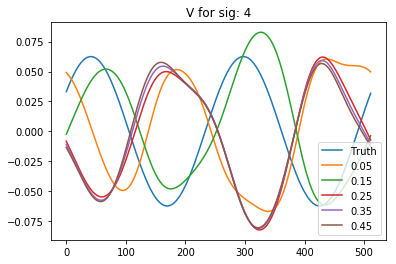

In [19]:
for ii in range(5):
    plt.figure()
    plt.plot(VT[ii])
    plt.plot(V_array[:, :, ii].T)
    plt.title(f'V for sig: {ii}')
    plt.legend(['Truth'] 
               + list(np.round(rho_array, decimals=2)))

In [54]:
sig_slice.stop

5


slice(0, 1, None)

slice(1, 3, None)

slice(3, 5, None)

slice(5, 7, None)

slice(7, 9, None)


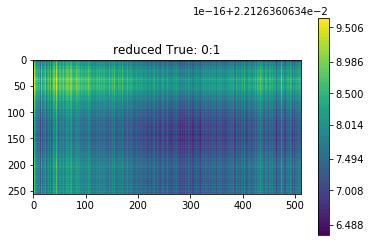

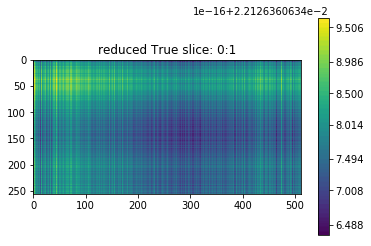

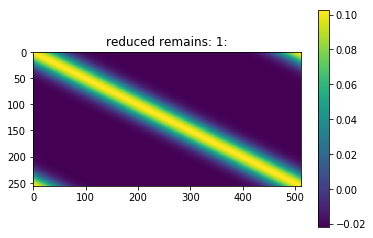

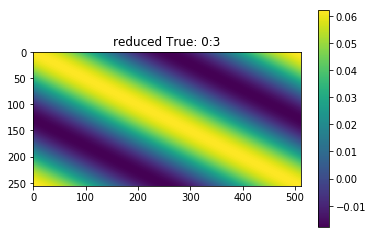

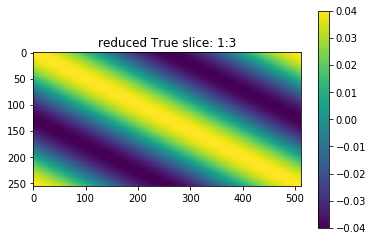

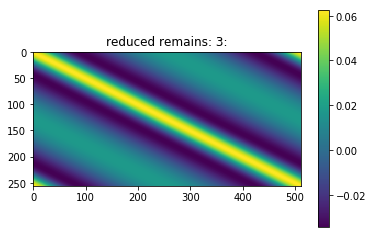

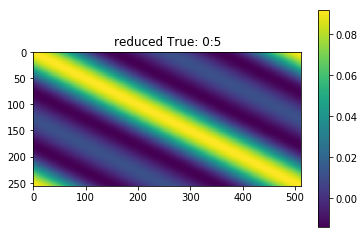

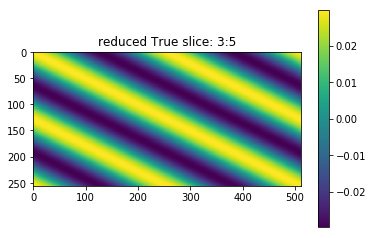

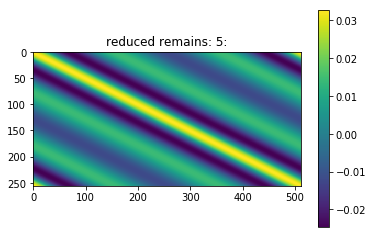

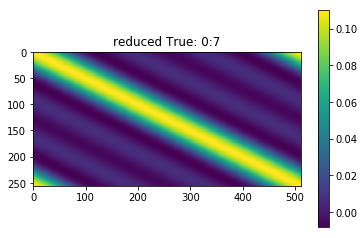

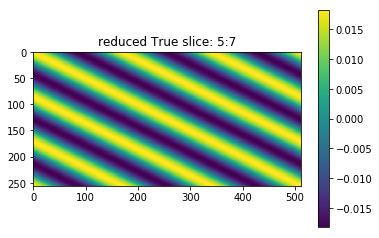

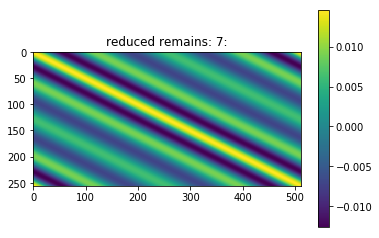

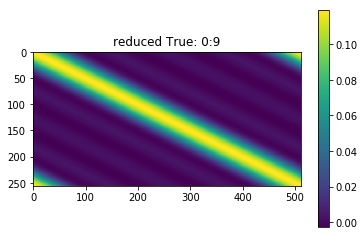

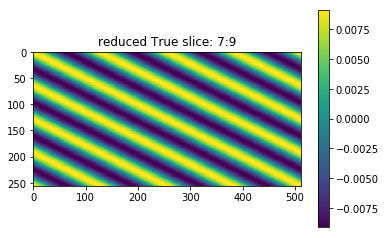

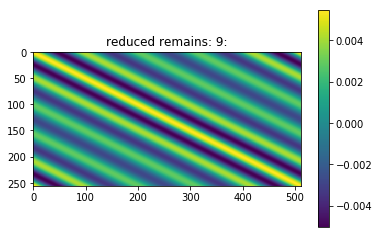

In [58]:
sig_array = np.concatenate(
    [[1], np.repeat([2], 4)])
last_sig = 0

for sig_count, sig_num in enumerate(sig_array):
    sig_slice = slice(last_sig, last_sig + sig_num)
    print('')
    print(sig_slice)
    last_sig = last_sig + sig_num
    
    true_reduced = (
        U[:, :last_sig]
        @ S[:last_sig, :last_sig]
        @ VT[:last_sig])
    
    true_reduced_slice = (
        U[:, sig_slice]
        @ S[sig_slice, sig_slice]
        @ VT[sig_slice])
    
    true_remains = (
        U[:, last_sig:]
        @ S[last_sig:, last_sig:]
        @ VT[last_sig:])

    imshow(true_reduced,
           title=f'reduced True: 0:{sig_slice.stop}',
           )
    
    imshow(true_reduced_slice,
           title=f'reduced True slice: {sig_slice.start}:{sig_slice.stop}',
           )
    
    imshow(true_remains,
           title=f'reduced remains: {sig_slice.stop}:',
           )


slice(0, 1, None)

slice(1, 2, None)

slice(2, 3, None)

slice(3, 4, None)

slice(4, 5, None)


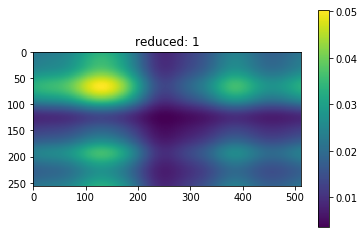

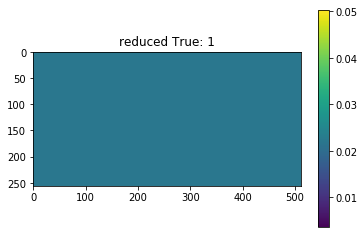

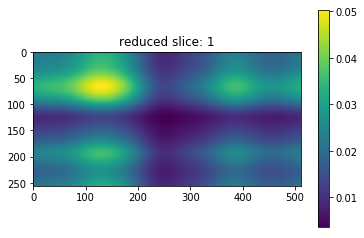

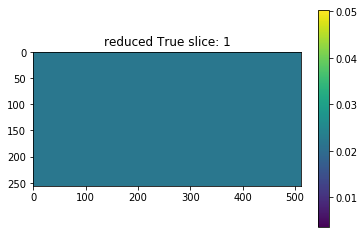

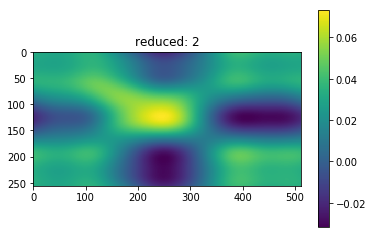

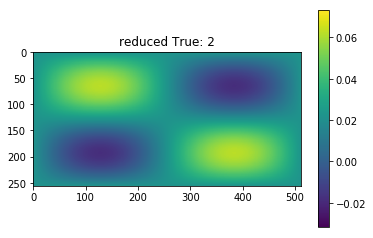

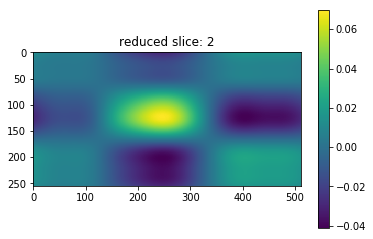

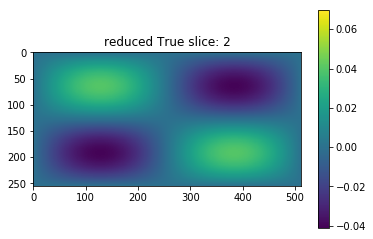

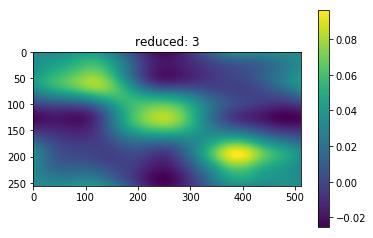

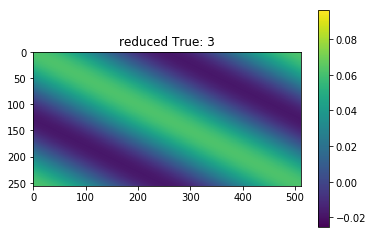

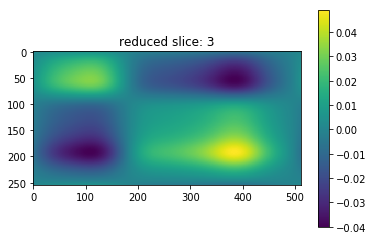

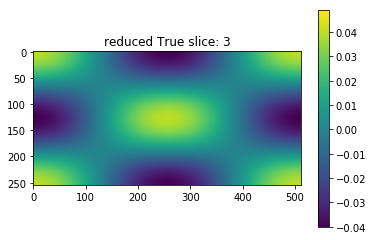

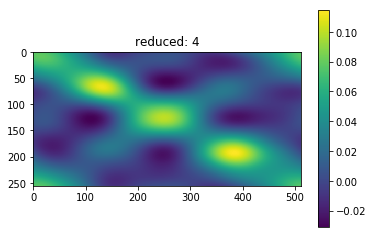

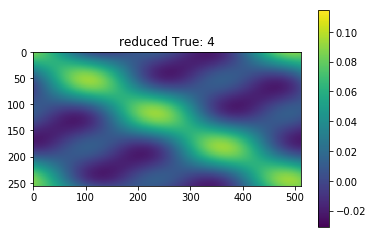

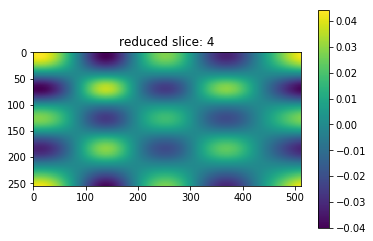

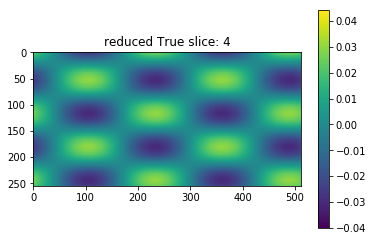

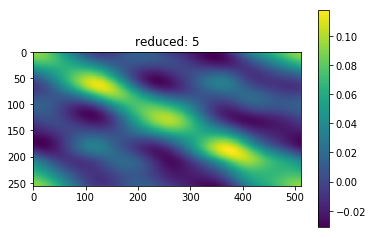

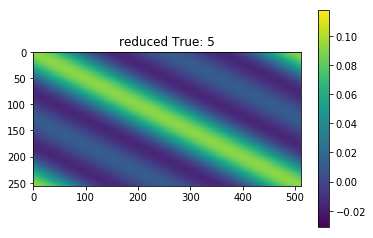

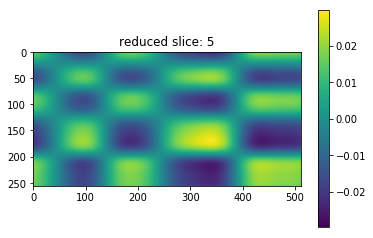

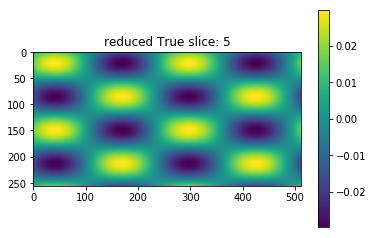

In [50]:
sig_array = np.concatenate(
    [[3], np.repeat([4], 3)])
sig_array = np.repeat([1], 5)
# sig_array = np.concatenate(
#     [[0], [3], np.repeat([4], 3)])
# sig_array = np.array([19])
last_sig = 0
opt_reduced = np.zeros([obs_size, dimension])
for sig_count, sig_num in enumerate(sig_array):
    sig_slice = slice(last_sig, last_sig + sig_num)
    print('')
    print(sig_slice)
    last_sig = last_sig + sig_num
    opt_reduced_slice = (
        U_array[-1 - sig_count, :, sig_slice]
        @ np.diag(s_array[-1 - sig_count, sig_slice])
        @ V_array[-1 - sig_count, :, sig_slice].T)
    opt_reduced += opt_reduced_slice
    true_reduced = (
        U[:, :last_sig]
        @ S[:last_sig, :last_sig]
        @ VT[:last_sig])
    true_reduced_slice = (
        U[:, sig_slice]
        @ S[sig_slice, sig_slice]
        @ VT[sig_slice])
#     this_V = V_array[-1 - sig_count, :, :last_sig]
#     Proj = np.eye(dimension) - thi
    vmin = np.min([
        opt_reduced.min(),
        true_reduced.min()
    ])
    vmax = np.max([
        opt_reduced.max(),
        true_reduced.max()
    ])
    imshow(opt_reduced,
           title=f'reduced: {last_sig}',
           vmin=vmin,
           vmax=vmax)
    imshow(true_reduced,
           title=f'reduced True: {last_sig}',
           vmin=vmin,
           vmax=vmax)
    
    vmin = np.min([
        opt_reduced_slice.min(),
        true_reduced_slice.min()
    ])
    vmax = np.max([
        opt_reduced_slice.max(),
        true_reduced_slice.max()
    ])
    imshow(opt_reduced_slice,
           title=f'reduced slice: {last_sig}',
           vmin=vmin,
           vmax=vmax)
    
    imshow(true_reduced_slice,
           title=f'reduced True slice: {last_sig}',
           vmin=vmin,
           vmax=vmax)


slice(0, 1, None)

slice(1, 3, None)

slice(3, 5, None)


/Users/harty/anaconda3/envs/multiloc/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)



slice(5, 7, None)

slice(7, 9, None)

slice(9, 11, None)


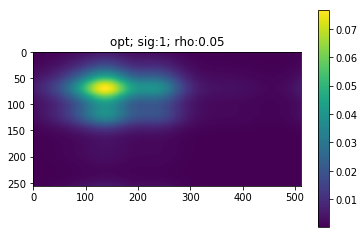

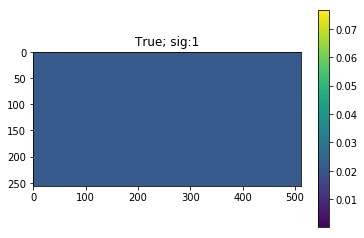

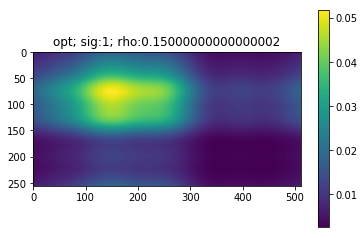

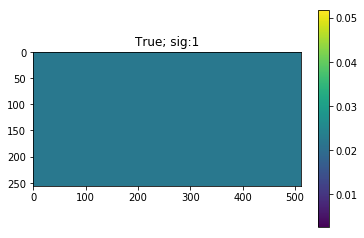

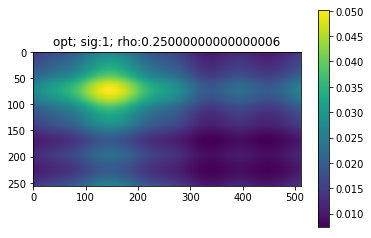

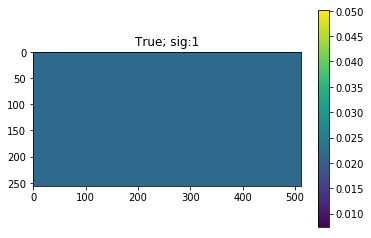

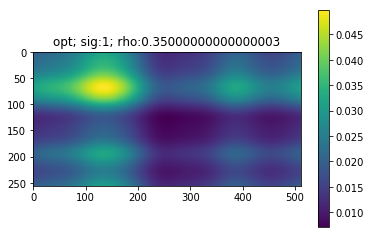

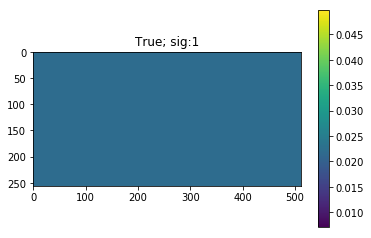

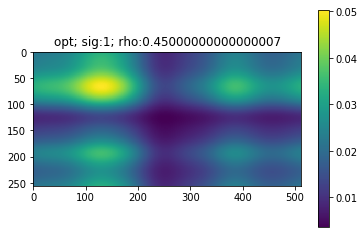

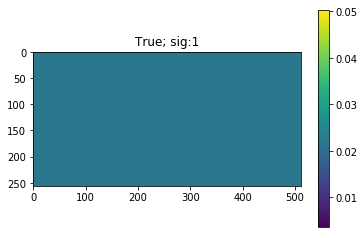

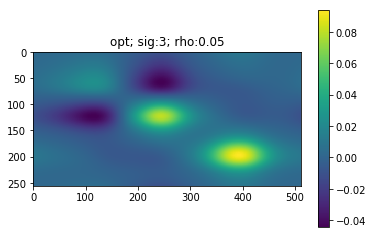

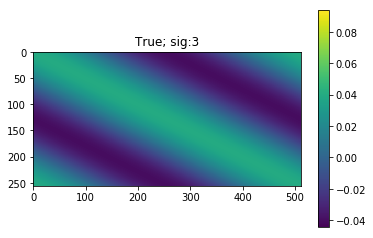

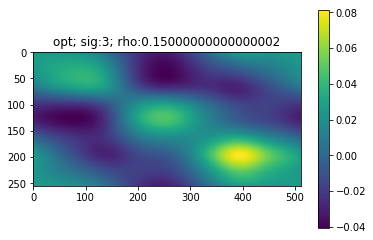

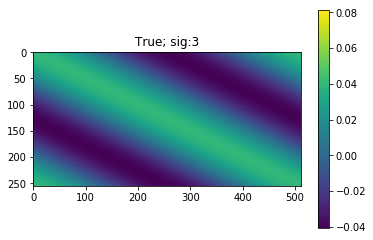

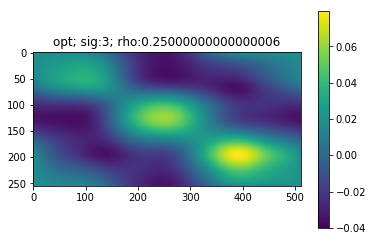

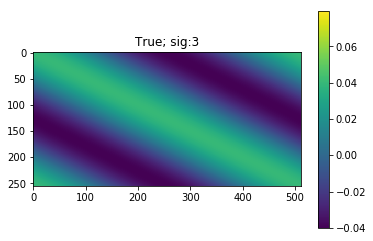

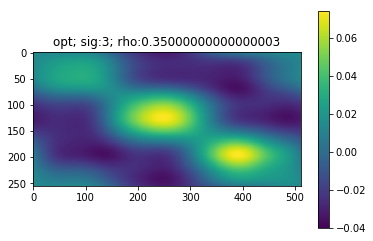

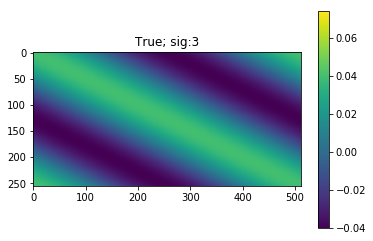

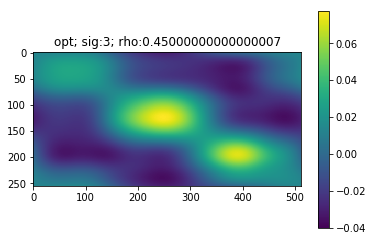

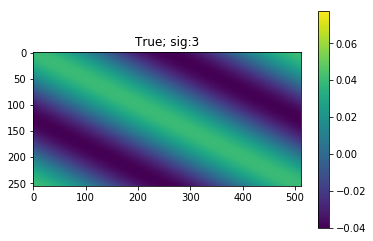

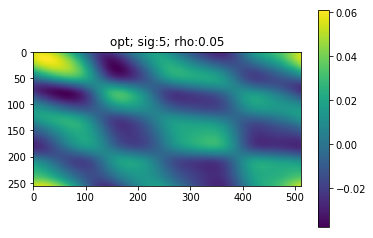

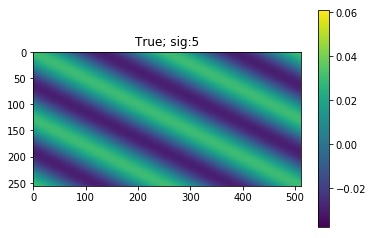

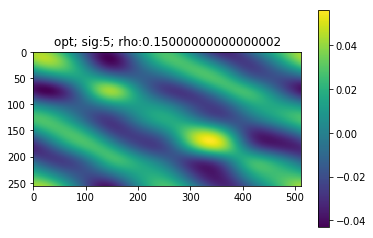

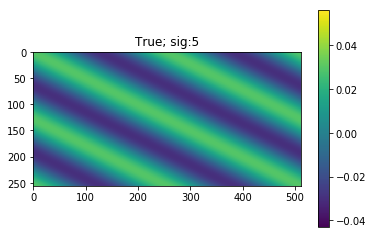

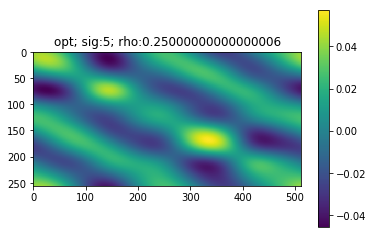

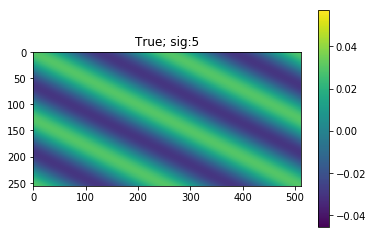

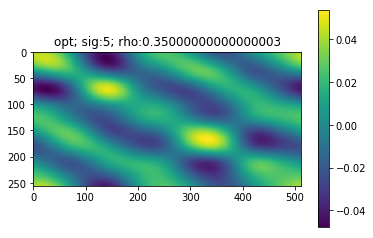

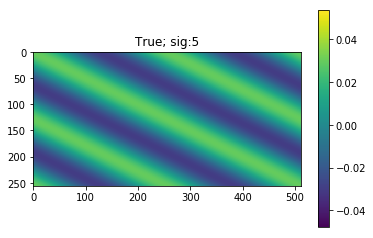

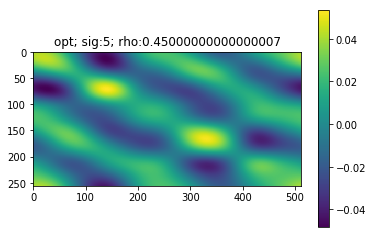

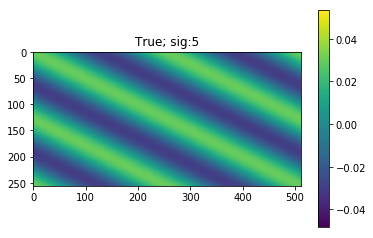

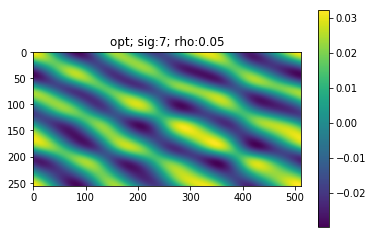

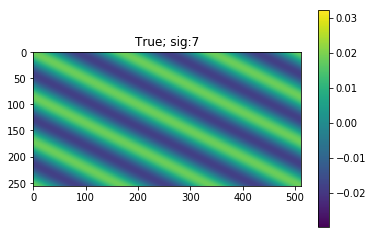

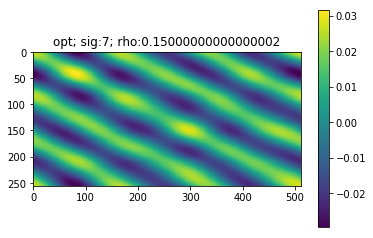

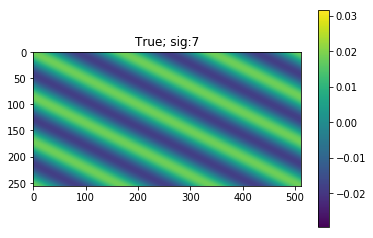

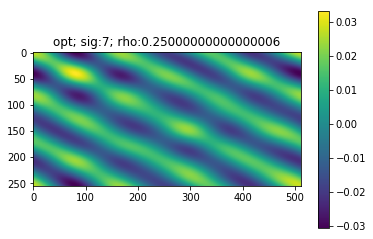

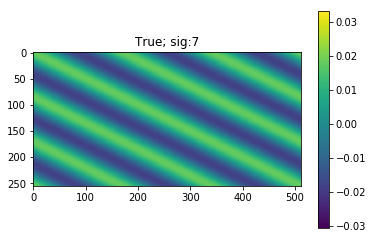

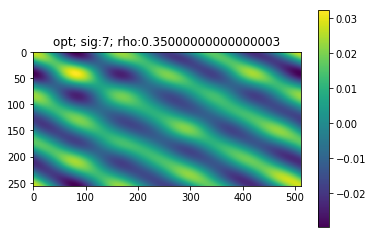

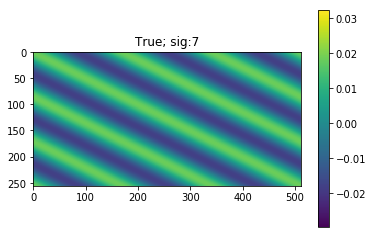

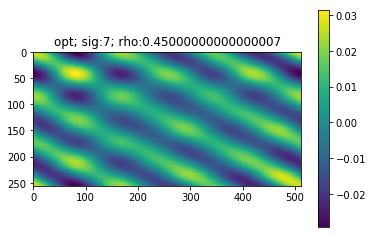

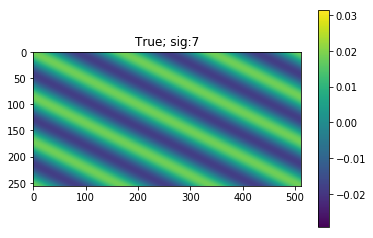

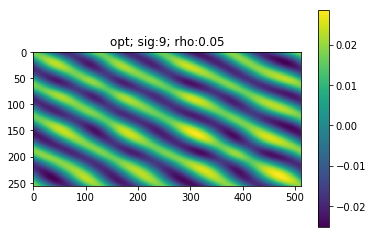

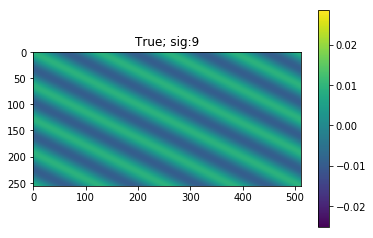

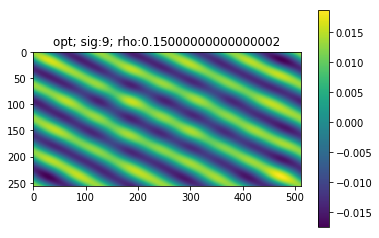

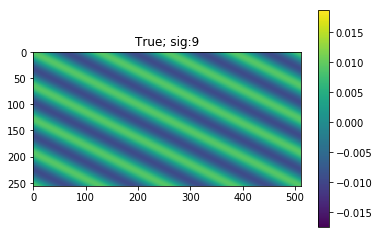

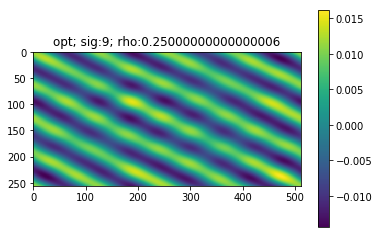

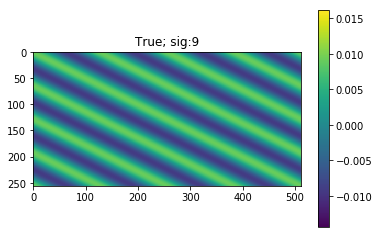

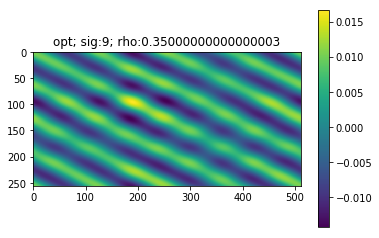

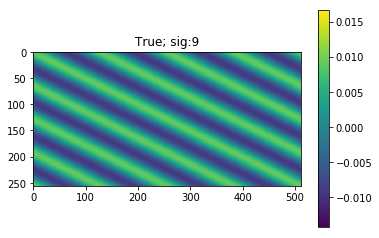

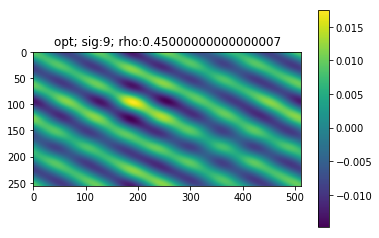

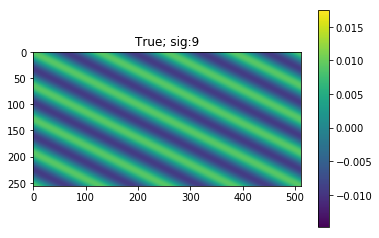

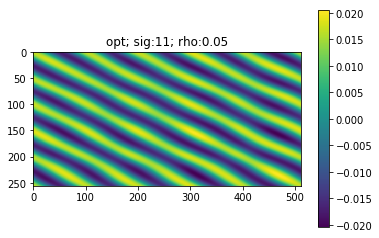

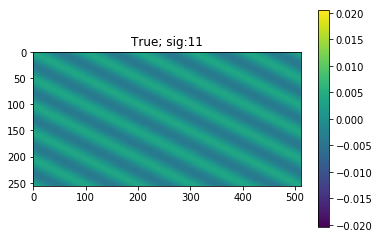

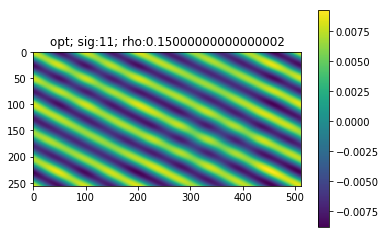

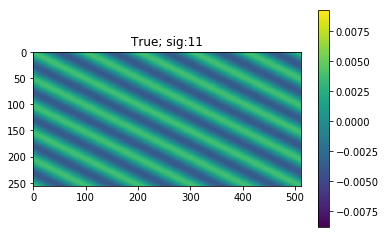

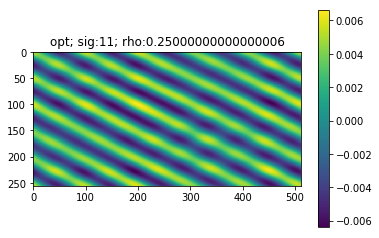

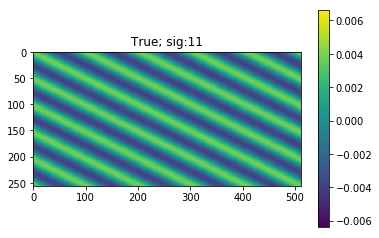

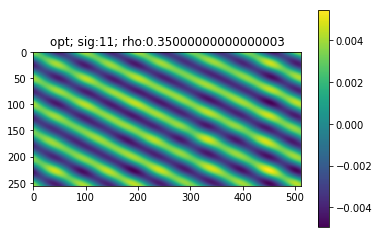

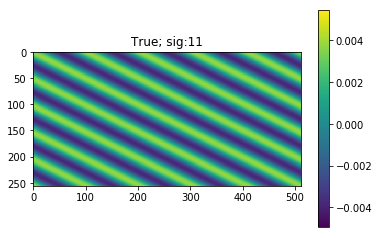

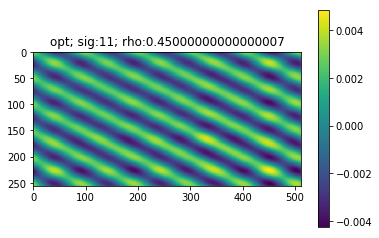

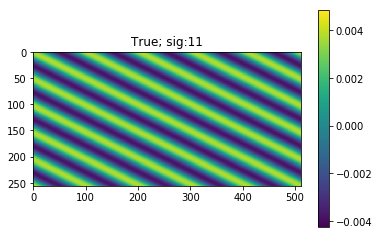

In [47]:
sig_array = np.concatenate(
    [[1], np.repeat([2], 5)])
last_sig = 0
opt_reduced = np.zeros([obs_size, dimension])
for sig_count, sig_num in enumerate(sig_array):
    sig_slice = slice(last_sig, last_sig + sig_num)
    print('')
    print(sig_slice)
    last_sig = last_sig + sig_num
    true_reduced = (
        U[:, :last_sig]
        @ S[:last_sig, :last_sig]
        @ VT[:last_sig])
    true_reduced_slice = (
        U[:, sig_slice]
        @ S[sig_slice, sig_slice]
        @ VT[sig_slice])
    for rho_count, loc_rho in enumerate(rho_array):
        opt_reduced_slice = (
            U_array[rho_count, :, sig_slice]
            @ np.diag(s_array[rho_count, sig_slice])
            @ V_array[rho_count, :, sig_slice].T)
        opt_reduced += opt_reduced_slice

#         vmin = np.min([
#             opt_reduced.min(),
#             true_reduced.min()
#         ])
#         vmax = np.max([
#             opt_reduced.max(),
#             true_reduced.max()
#         ])
#         imshow(opt_reduced,
#                title=f'reduced: {last_sig}',
#                vmin=vmin,
#                vmax=vmax)
#         imshow(true_reduced,
#                title=f'reduced True: {last_sig}',
#                vmin=vmin,
#                vmax=vmax)

        vmin = np.min([
            opt_reduced_slice.min(),
            true_reduced_slice.min()
        ])
        vmax = np.max([
            opt_reduced_slice.max(),
            true_reduced_slice.max()
        ])
        imshow(opt_reduced_slice,
               title=f'opt; sig:{last_sig}; rho:{loc_rho}',
               vmin=vmin,
               vmax=vmax)

        imshow(true_reduced_slice,
               title=f'True; sig:{last_sig}',
               vmin=vmin,
               vmax=vmax)